Using device: cuda:0


/tmp/ipykernel_1789238/1747444312.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


Loaded trained weights from swin_best.pth
Number of test samples: 543


Testing:   0%|          | 0/17 [00:00<?, ?it/s]/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/m

Test Accuracy: 36.65%

Classification Report:
               precision    recall  f1-score   support

No Adulterant     0.0000    0.0000    0.0000        40
    Detergent     0.5789    0.4552    0.5097       145
      Shampoo     0.1250    0.0071    0.0135       140
 StarchPowder     0.3465    1.0000    0.5147       114
        Water     0.2222    0.1731    0.1946       104

     accuracy                         0.3665       543
    macro avg     0.2545    0.3271    0.2465       543
 weighted avg     0.3021    0.3665    0.2849       543



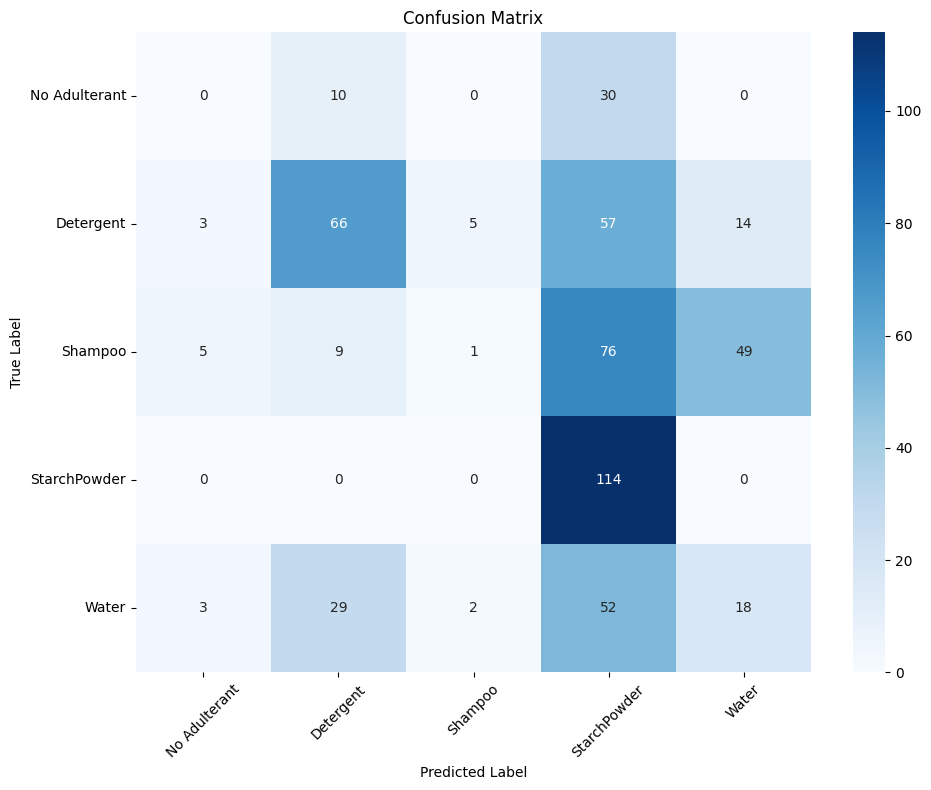

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from timm.models.swin_transformer import SwinTransformer
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the same dataset class you used in training
class MilkAdulterationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform
        self.class_map = {
            "None": 0,
            "Detergent": 1,
            "Shampoo": 2,
            "StarchPowder": 3,
            "Water": 4
        }

        for fat in os.listdir(root_dir):
            fat_path = os.path.join(root_dir, fat)
            if not os.path.isdir(fat_path):
                continue

            for percent in os.listdir(fat_path):
                percent_path = os.path.join(fat_path, percent)

                if percent == '0':
                    # No adulterant
                    for img_name in os.listdir(percent_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.data.append({
                                "img_path": os.path.join(percent_path, img_name),
                                "label": self.class_map["None"]
                            })
                else:
                    # With adulterant
                    for adulterant in os.listdir(percent_path):
                        adulterant_path = os.path.join(percent_path, adulterant)
                        if not os.path.isdir(adulterant_path):
                            continue
                            
                        # Handle case variations in folder names
                        adulterant_lower = adulterant.lower()
                        if 'starch' in adulterant_lower:
                            label_name = "StarchPowder"
                        elif 'detergent' in adulterant_lower:
                            label_name = "Detergent"
                        elif 'shampoo' in adulterant_lower:
                            label_name = "Shampoo"
                        elif 'water' in adulterant_lower:
                            label_name = "Water"
                        else:
                            label_name = "None"
                            
                        for img_name in os.listdir(adulterant_path):
                            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                                self.data.append({
                                    "img_path": os.path.join(adulterant_path, img_name),
                                    "label": self.class_map[label_name]
                                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample["img_path"]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample["label"]

# Define the same transforms used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class mapping (should match your training)
index_to_class = {
    0: "No Adulterant",
    1: "Detergent",
    2: "Shampoo",
    3: "StarchPowder",
    4: "Water"
}

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=list(index_to_class.values()), 
        digits=4
    ))
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, list(index_to_class.values()))
    
    return accuracy

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def main():
    # Set device (match your training setup)
    device_list = [0]  # Using first GPU by default, adjust if needed
    device = torch.device(f'cuda:{device_list[0]}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize model (must match training exactly)
    num_classes = len(index_to_class)
    model = SwinTransformer(
        img_size=224,
        patch_size=4,
        in_chans=3,
        num_classes=num_classes,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        pretrained=True
    )
    
    # Load trained weights
    weights_path = 'swin_best.pth'  # or 'best_model.pth' depending on which you want to use
    state_dict = torch.load(weights_path, map_location=device)
    
    # Handle DataParallel wrapping if needed
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=device_list)
    
    model = model.to(device)
    
    # Handle loading for both DataParallel and single GPU cases
    if all(k.startswith('module.') for k in state_dict.keys()):
        if not isinstance(model, nn.DataParallel):
            # Load DataParallel model onto single GPU
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    print(f"Loaded trained weights from {weights_path}")
    
    # Prepare test dataset
    test_root = 'test_data/RGB_TEST'  # Change this to your test dataset path
    test_dataset = MilkAdulterationDataset(test_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    print(f"Number of test samples: {len(test_dataset)}")
    
    # Test the model
    test_model(model, test_loader, device)

if __name__ == '__main__':
    main()